## Ising Model Data Generation
Here, we generate our training, validation, and test set data. We perform Monte Carlo simulations of the 2-D Ising model for different temperatures and save the output. 

Each sample is saved as a .npy (binary numpy file), and consists of an $L$x$L$ matrix of $1$ and $-1$, indicating spin-up and spin-down, respectively.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import multiprocessing as mp
from itertools import repeat
%matplotlib inline

Set the save locations for each of the data sets.

In [2]:
train_data = '../../data/Ising/train/'
test_data = '../../data/Ising/test/'
valid_data = '../../data/Ising/valid/'

Function to create and randomly fill an $L$x$L$ array. 

In [3]:
def createArray(L):
    mat = np.random.randint(0,2,size=(L,L), dtype=int)
    mat[mat==0] = -1  
    return mat

In [5]:
def iterate(mat,T,calcE):
    L,_ = mat.shape
      
    order1 = np.arange(L)
    order2 = np.arange(L)
    np.random.shuffle(order1)
    np.random.shuffle(order2)
    avgE = 0.0
    for i in order1:
        for j in order2:
            spin_current = mat[i,j]
            spin_potential = spin_current*(-1)
            neighbor_sum = mat[(i+1)%L,j]+mat[(i-1)%L,j]+mat[i,(j+1)%L]+mat[i,(j-1)%L]
            E_current = -spin_current*neighbor_sum
            E_potential = -spin_potential*neighbor_sum
            E_diff = E_potential - E_current
            if E_diff < 0:
                mat[i,j] = spin_potential
            elif np.random.random()<= np.exp(-float(E_diff)/T):
                mat[i,j] = spin_potential
    if calcE:        
        for i in order1:
            for j in range(0,L):
                spin_final = mat[i,j]
                E_final = -spin_final*neighbor_sum
                avgE+=float(E_final)
    
        avgE/=float(L**2)                   
        return avgE
    #else:
    #    return updateMat
            

In [4]:
def flipCluster(mat,cluster):
    for pair in cluster:
        i,j=pair
        mat[i,j]*=-1

In [5]:
def iterateWolff(mat,T,calcE):
    L,_ = mat.shape
    tracker = np.zeros((L,L))
    
    i,j = np.random.randint(0,L,size=2)
    spin = mat[i,j]
    stack = [(i,j)]
    tracker[i,j]=1
    
    cluster = [(i,j)]
    while len(stack)>0:
        i,j = stack.pop()
        neighbors = [(i,(j+1)%L),(i,(j-1)%L),((i+1)%L,j),((i-1)%L,j)]
        for pair in neighbors:
            l,m = pair
            if (mat[l,m]==spin and tracker[l,m]==0 and np.random.random()< (1.0-np.exp(-2.0/T))):
                cluster.append((l,m))
                stack.append((l,m))
                tracker[l,m]=1
            
    flipCluster(mat,cluster)
            
    if calcE:
        avgE=0.0
        for i in range(L):
            for j in range(L):
                spin_final = mat[i,j]
                neighbor_sum = mat[(i+1)%L,j]+mat[(i-1)%L,j]+mat[i,(j+1)%L]+mat[i,(j-1)%L]
                E_final = -spin_final*neighbor_sum
                avgE+=float(E_final)
    
        avgE/=float(L**2)                   
        return avgE
    #else:
    #    return updateMat
            

In [8]:
#Iterate function for triangular lattice 
def iterateTri(mat,T,calcE):
    n,_ = mat.shape
    N = n-2
    
    order1 = np.arange(1,N+1)
    order2 = np.arange(1,N+1)
    np.random.shuffle(order1)
    np.random.shuffle(order2)
    
    updateMat=mat
    avgE = 0.0
    for i in order1:
        for j in order2:
            spin_current = mat[i,j]
            spin_potential = spin_current*(-1)
            E_current = -spin_current*(mat[i+1,j]+mat[i-1,j]+mat[i,j+1]+mat[i,j-1]+mat[i+1,j+1]+mat[i-1,j-1])
            E_potential = -spin_potential*(mat[i+1,j]+mat[i-1,j]+mat[i,j+1]+mat[i,j-1]+mat[i+1,j+1]+mat[i-1,j-1])
            E_diff = E_potential - E_current
            if E_diff < 0:
                updateMat[i,j] = spin_potential
                #avgE+=float(E_potential)
            elif np.random.random()<= np.exp(-float(E_diff)/T):
                updateMat[i,j] = spin_potential
                #avgE+=float(E_potential)
            #else:
                #avgE+=float(E_current)
            updateMat[:,0] = updateMat[:,N]
            updateMat[:,N+1] = updateMat[:,1]
    
            updateMat[0,:] = updateMat[N,:]
            updateMat[N+1,:] = updateMat[1,:]

    if calcE:        
        for i in order1:
            for j in range(1,N+1):
                spin_final = mat[i,j]
                E_final = -spin_final*(mat[i+1,j]+mat[i-1,j]+mat[i,j+1]+mat[i,j-1])
                avgE+=float(E_final)
    
        avgE/=float(N**2)                   
        return updateMat, avgE
    else:
        return updateMat

In [6]:
def iterateWolffTri(mat,T,calcE):
    L,_ = mat.shape
    tracker = np.zeros((L,L))
    
    i,j = np.random.randint(0,L,size=2)
    spin = mat[i,j]
    stack = [(i,j)]
    tracker[i,j]=1
    
    cluster = [(i,j)]
    while len(stack)>0:
        i,j = stack.pop()
        neighbors = [(i,(j+1)%L),(i,(j-1)%L),((i+1)%L,j),((i-1)%L,j),((i+1)%L,(j+1)%L),((i-1)%L,(j-1)%L)]
        for pair in neighbors:
            l,m = pair
            if (mat[l,m]==spin and tracker[l,m]==0 and np.random.random()< (1.0-np.exp(-2.0/T))):
                cluster.append((l,m))
                stack.append((l,m))
                tracker[l,m]=1
            
    flipCluster(mat,cluster)
            
    if calcE:
        avgE=0.0
        for i in range(L):
            for j in range(L):
                spin_final = mat[i,j]
                neighbor_sum = mat[(i+1)%L,j]+mat[(i-1)%L,j]+mat[i,(j+1)%L]+mat[i,(j-1)%L]+mat[(i+1)%L,(j+1)%L]+mat[(i-1)%L,(j-1)%L]
                E_final = -spin_final*neighbor_sum
                avgE+=float(E_final)
    
        avgE/=float(L**2)                   
        return avgE

In [7]:
def calcCorr(mat, L, dist):
    # Calculate the correlation function for r = dist
    # dist should be less than L/2
    # Samples from the diagonal
    products1 = 0
    avg1 = 0
    avg2 = 0
    for i in range(L):
        for j in range(L):
            idx1 = (i+dist)%L
            idx2 = (i-dist)%L
            idx3 = (j+dist)%L
            idx4 = (j-dist)%L
            products1 += mat[i,j]*(mat[i,idx3] + mat[idx1,j] + mat[i,idx4] + mat[idx2,j])
            avg1 += mat[i,j]
            avg2 += (mat[i,idx3] + mat[idx1,j] + mat[i,idx4] + mat[idx2,j])
        
    products1/=(4.0*L*L)
    avg1/= float(L*L)
    avg2/= (4.0*L*L)
    corrFunc = products1 - avg1*avg1
    return dist, corrFunc

In [8]:
def corrLength(corrs):
    dist = np.arange(1,len(corrs)+1,dtype=float)
    m,b = np.polyfit(dist,np.log(corrs),1)
    
    length = -1.0/m
    return length

In [9]:
def simulate(mat,T,steps):
    #Runs MC for number of steps
    calcE=False
    for step in range(steps):
        #iterate(mat,T,calcE)
        iterateWolff(mat,T,calcE)

In [10]:
def simulateTri(mat,T,steps):
    #Runs MC for number of steps
    calcE=False
    for step in range(steps):
        #iterate(mat,T,calcE)
        iterateWolffTri(mat,T,calcE)

In [11]:
def generateSamples(T,L,steps,samples,dirPath):
    for i in range(1,samples+1):
        mat = createArray(L)
        simulate(mat,T,steps)
        
        if T<2.27:
            category = "low"
        else:
            category = "high"
        
        path = os.path.join(dirPath,f"{category}_{T:.2f}_{i}_")
        np.save(path,mat)

In [12]:
def generateSamplesTri(T,L,steps,samples,dirPath):
    for i in range(1,samples+1):
        mat = createArray(L)
        simulateTri(mat,T,steps)
        
        if T<3.65:
            category = "low"
        else:
            category = "high"
        
        path = os.path.join(dirPath,f"{category}_{T:.2f}_{i}_")
        np.save(path,mat)

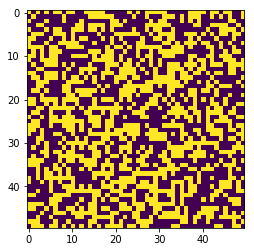

In [13]:
mat=createArray(50)
plt.imshow(mat)

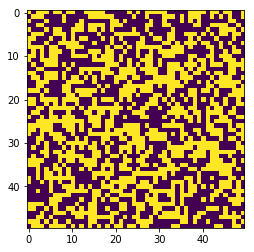

In [14]:
simulateTri(mat,6.27,30)
plt.imshow(mat)

## Generate training and validation sets

In [37]:
Temps = np.arange(1.5,2.5,0.1)

In [39]:
Temps = np.arange(2.5,3.2,0.1)

In [41]:
Temps = np.arange(1.5,3.2,0.1)

In [15]:
Temps = np.arange(2.0,2.6,0.1)

In [16]:
Temps

array([2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6])

In [18]:
samples = 100
L=20
steps = 1000
tester=zip(Temps,repeat(L),repeat(steps),repeat(samples),repeat(valid_data))
p = mp.Pool(4)
#p.map(run_one, Temps)
p.starmap(generateSamples, tester)
p.close()
p.join()


In [72]:
tri_test_data = '../../data/Ising/testTri/'

In [73]:
Temps = np.arange(2.5,4.5,0.1)

In [74]:
samples = 100
L=20
steps = 1000
tester=zip(Temps,repeat(L),repeat(steps),repeat(samples),repeat(tri_test_data))
p = mp.Pool(4)
#p.map(run_one, Temps)
p.starmap(generateSamplesTri, tester)
p.close()
p.join()

In [200]:
samples = 3
L=20
steps = 3
for T in Temps:
    generateSamples(T,L,steps,samples,train_data)


100%|██████████| 3/3 [00:00<00:00, 73.11it/s]

### Load and plot a generated sample

In [152]:
data_files=os.listdir(train_data)

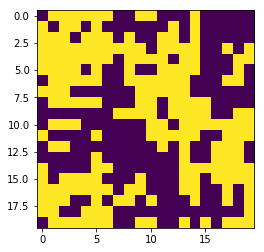

In [153]:
sampleMat=np.load(os.path.join(train_data,data_files[20]))
plt.imshow(sampleMat)

In [46]:
mat=createArray(20)
steps=1000
avgE = np.zeros(steps)
for step in tqdm(range(steps)):
    avgE[step]=iterateWolff(mat,2.5,True)
    #avgE[step]=iterate(mat,2.1,True)

100%|██████████| 1000/1000 [00:01<00:00, 656.79it/s]


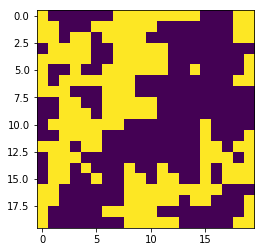

In [47]:
plt.imshow(mat)

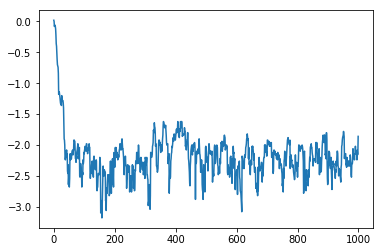

In [48]:
plt.plot(avgE)

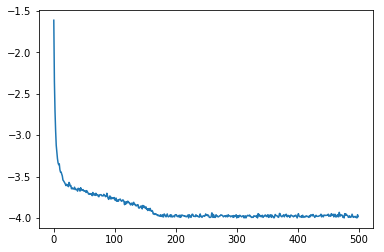

In [72]:
plt.plot(avgE)

## Calculate correlations

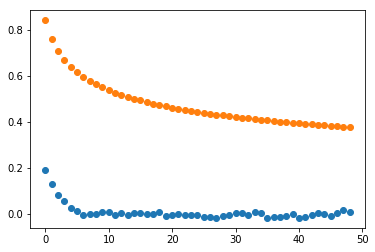

In [45]:
corr = np.zeros(int(100/2))
for i in range(1,int(100/2)):
    _,corr[i] = calcCorr(mat,100,i)

corr_theory = np.fromfunction(lambda i : (i+1.0)**-0.25, shape=(50,),dtype=float)
plt.plot(corr[1:],'o')
plt.plot(corr_theory[1:],'o')